# Naive methods

This notebook contains different naive methods that can be used to "combine" normal data with edge data.\
To obtain data $\mathcal{D}$ we draw $n=10000$ samples from the multivariate normal distribution $\begin{bmatrix}X\\Y\end{bmatrix} \sim \mathcal{N}\left(\begin{bmatrix}0\\ 0\end{bmatrix}, \begin{bmatrix} 2 & 0.5 \\ 0.5 & 1\end{bmatrix} \right)$.
From this data we extract normal and edge data, where we define a datapoint to be an edge case sample in case $Y \geq c$, where we take $c=1$. This gives us $N$ edge case samples. We use the first $M=\frac{N}{10}$ datapoints from the extracted data to obtain the normal data. The remainder of the data is not used. We denote the normal data with $\mathcal{D}_{(norm)}$ and the edge data with $\mathcal{D}_{(edge)}$. Note that there is an overlap in $\mathcal{D}^{(norm)}$ and $\mathcal{D}^{(edge)}$.

The objective is to somehow use $\mathcal{D}^{(edge)}$ to improve (i.e. reduce uncertainty) the estimation of the pdf of $\mathcal{D}^{(norm)}$. In particular we are interested in estimating the pdf of $X$, denoted by $f_{X}^{(norm)}$.

We implement a combination of 2 of the described methods in the "modellen practicum" document; that is, we estimate $f_X$ by:

\begin{align}p(Y\leq c) \cdot \int_{-\infty}^c f_{X,Y}^{(norm)}(x,y) dy + p(Y>c) \cdot \int_{c}^\infty f_{X,Y}^{(edge)}(x,y) dx.\end{align}

Where $f_{X,Y}^{(norm)}$ is estimated by applying KDE on $\mathcal{D}^{(norm)} - \mathcal{D}^{(edge)}$; and $f_{X,Y}^{(edge)}$ is estimated by applying KDE on $\mathcal{D}^{(edge)}$. We mirror the data and clamp the pdfs at the boundaray $c$.
<!-- 2. Estimate $F_X(x) \approx \int_{-\infty}^x \int_{-\infty}^c f_{X,Y}(x,y) dy dx + \int_{-\infty}^x \int_{c}^\infty f_{X,Y}(x,y) dy dx$
3. Estimate $f_x \approx p(Y\leq c) \cdot f_x + p(Y>c) \cdot f_x$ -->


In [59]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats
import seaborn as sns

In [98]:
# Constants
n_samples = 10000
c = 1

# Parameters
mu_X = 0
mu_Y = 0
sigma_X_sq = 2
sigma_Y_sq = 1
cov = 0.5


# Generate data
def generate_data():
    data = np.random.multivariate_normal(np.array([mu_X, mu_Y]), np.matrix([[sigma_X_sq, cov], [cov, sigma_Y_sq]]), n_samples)

    # Filter data and compute N, M
    edge_data = data[data[:,1] > c]
    normal_data = data[:len(edge_data) // 10]

    # Ensure no edge case data in normal data
    # Probability of edge and normal data, based on normal data only
    normal_data_filtered = normal_data[normal_data[:,1] <= c]
    p_normal = len(normal_data_filtered) / len(normal_data)
    p_edge = 1 - p_normal
    
    return normal_data, edge_data, normal_data_filtered, p_normal, p_edge

normal_data, edge_data, normal_data_filtered, p_normal, p_edge = generate_data()

In [91]:
# KDE estimates of normal and edge data
baseline_kde = scipy.stats.gaussian_kde(normal_data.T)
normal_kde = scipy.stats.gaussian_kde(normal_data_filtered.T)
edge_kde = scipy.stats.gaussian_kde(edge_data.T)

def baseline_estimator(x):
    return scipy.integrate.quad(lambda y: baseline_kde([x, y]), -np.inf, np.inf)[0]

def improved_estimator(x):
    integral_till_c = scipy.integrate.quad(lambda y: normal_kde([x, y]) + normal_kde([x, 2 * c - y] if y < c else 0), -np.inf, c)[0]
    integral_from_c = scipy.integrate.quad(lambda y: edge_kde([x, y]) + edge_kde([x, 2 * c - y] if y >= c else 0), c, np.inf)[0]
    return p_normal * integral_till_c + p_edge * integral_from_c



In [95]:
# KDE plot of X
x = np.linspace(-6, 6 , 30)
f_x = scipy.stats.norm.pdf(x, mu_X, np.sqrt(sigma_X_sq))
f_x_baseline = [baseline_estimator(xv) for xv in x]
f_x_improved = [improved_estimator(xv) for xv in x]

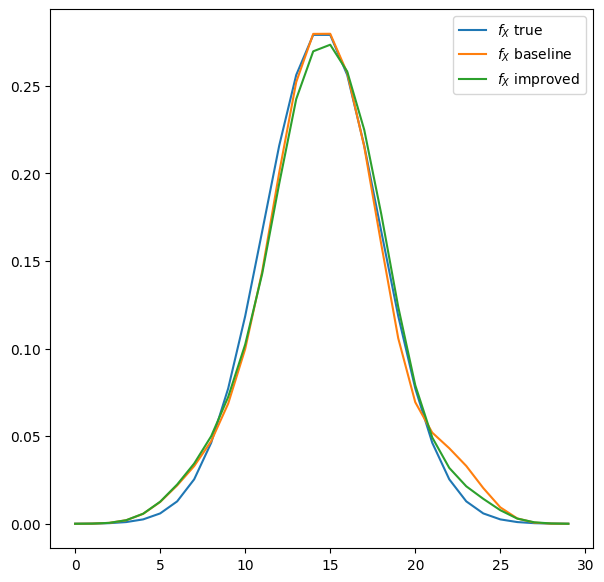

In [94]:
fig, axs = plt.subplots(1, 1, figsize=(7,7))
axs.plot(f_x, label='$f_X$ true')
axs.plot(f_x_baseline, label='$f_X$ baseline')
axs.plot(f_x_improved, label='$f_X$ improved')
# sns.plot(f_x_improved)
plt.legend()

To get get the variance we run the experiment a number of times. Each time we resample data from the considered multivariate normal distribution.

In [137]:
import json
from tqdm import tqdm

f_x_baseline = []
f_x_improved = []

for i in tqdm(range(200)):
    normal_data, edge_data, normal_data_filtered, p_normal, p_edge = generate_data()
    
    # KDE estimates of normal and edge data
    baseline_kde = scipy.stats.gaussian_kde(normal_data.T)
    normal_kde = scipy.stats.gaussian_kde(normal_data_filtered.T)
    edge_kde = scipy.stats.gaussian_kde(edge_data.T)
    
    # Compute f_x for bot estimators
    x = np.linspace(-6, 6 , 40)
    f_x_baseline.append([baseline_estimator(xv) for xv in x])
    f_x_improved.append([improved_estimator(xv) for xv in x])
    with open('f_x_baseline.json', 'w') as f: json.dump({"f_x":f_x_baseline}, f,indent=2)  
    with open('f_x_improved.json', 'w') as f: json.dump({"f_x":f_x_improved}, f, indent=2)
    
    

 75%|███████▌  | 150/200 [47:03<15:41, 18.82s/it]  


KeyboardInterrupt: 

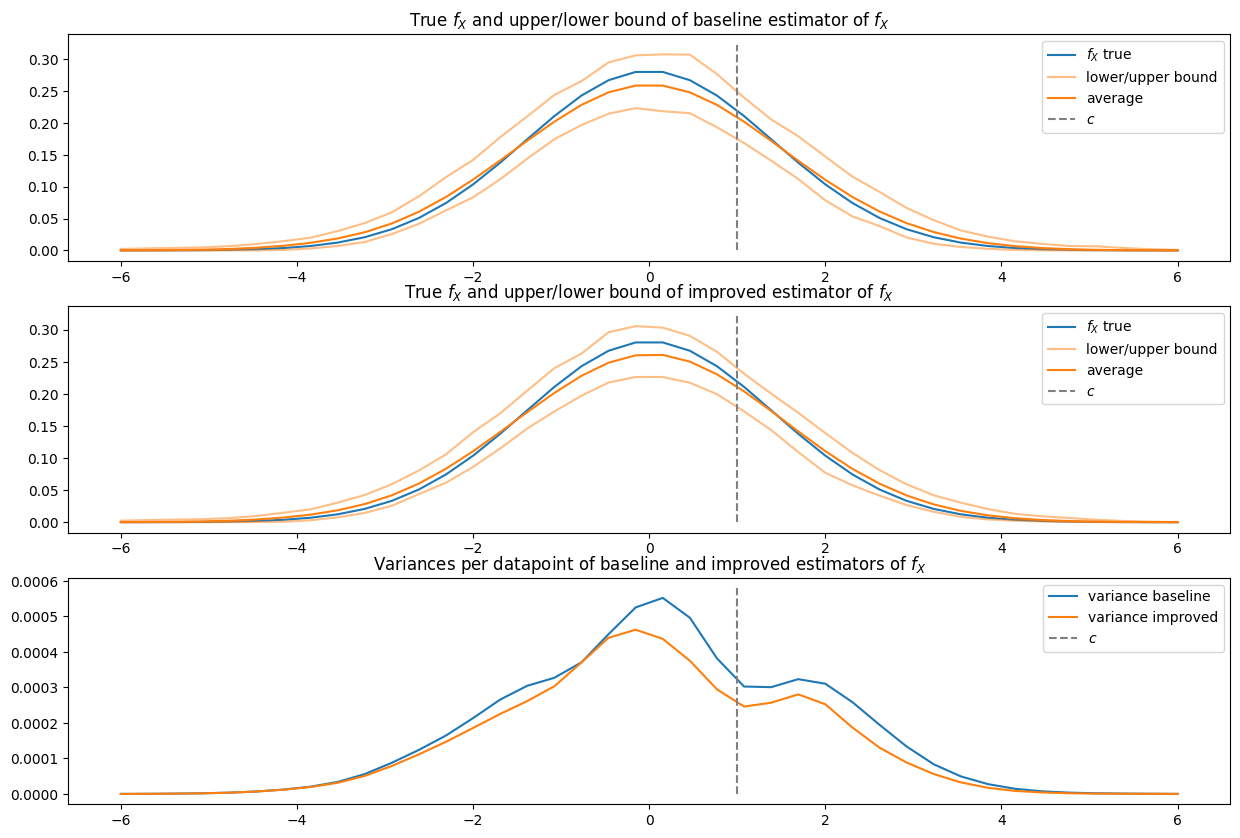

In [207]:
with open('f_x_baseline.json', 'r') as f: f_x_baseline = np.array(json.load(f)['f_x'][:80])
with open('f_x_improved.json', 'r') as f: f_x_improved = np.array(json.load(f)['f_x'][:80])

f_x_baseline_T = f_x_baseline.T
f_x_baseline_T.sort(axis=1)
f_x_improved_T = f_x_improved.T
f_x_improved_T.sort(axis=1)

lower_bound = int(0.025 * len(f_x_baseline_T[0]))
upper_bound = int(0.975 * len(f_x_baseline_T[0]))

x = np.linspace(-6, 6 , 40)
f_x = scipy.stats.norm.pdf(x, mu_X, np.sqrt(sigma_X_sq))
baseline_var = np.var(f_x_baseline_T, axis=1)
improved_var = np.var(f_x_improved_T, axis=1)


fig, axs = plt.subplots(3, 1, figsize=(15,10))
axs[0].plot(x, f_x, label='$f_X$ true')
axs[0].plot(x, f_x_baseline_T[:,lower_bound], label='lower/upper bound', alpha=0.5, color='tab:orange')
axs[0].plot(x, f_x_baseline_T[:,upper_bound], alpha=0.5, color='tab:orange')
axs[0].plot(x, np.average(f_x_baseline_T, axis=1), label='average')
axs[0].set_title('True $f_X$ and upper/lower bound of baseline estimator of $f_X$')

axs[1].plot(x, f_x, label='$f_X$ true')
axs[1].plot(x, f_x_improved_T[:,lower_bound], label='lower/upper bound', alpha=0.5, color='tab:orange')
axs[1].plot(x, f_x_improved_T[:,upper_bound], alpha=0.5, color='tab:orange')
axs[1].plot(x, np.average(f_x_improved_T, axis=1), label='average')
axs[1].set_title('True $f_X$ and upper/lower bound of improved estimator of $f_X$')

axs[2].plot(x, baseline_var, label='variance baseline')
axs[2].plot(x, improved_var, label='variance improved')
axs[2].set_title('Variances per datapoint of baseline and improved estimators of $f_X$')

for ax in axs:
    _, top = ax.get_ylim()
    ax.vlines(c, 0, top, linestyles=['dashed'], colors=['gray'], label='$c$') 
    ax.legend()


In [1]:
# Print the KL divergence between the true and estimated PDFs
print(f"KL(f_X, avg. baseline): {sum(scipy.special.rel_entr(f_x, np.average(f_x_baseline_T, axis=1)))}")
print(f"KL(f_X, avg. improved): {sum(scipy.special.rel_entr(f_x, np.average(f_x_improved_T, axis=1)))}")

NameError: name 'scipy' is not defined

# !!!The remainder of this notebook contains notes and some other tryouts!!!

### Paper 1
1. Use grid based method to estimate CDF $\hat{y}$
2. Use estimated CDF as target in a NN to obtain $\tilde{y}$
3. Differentiate $\tilde{y}$ w.r.t. the $N$ input datapoints to obtain the estimated PDF

Note that the differentation is analytical. However, errors are introduced in steps 1 and 2.

### Considered search queries

- Incorperating event data in probability density function estimation
- Extreme value estimation
- Reducing uncertainty by incorporating unlikely event data


# Resampling data
Note that we have more edge data than normal data and that we can compute the probability of edge cases in normal data ($p_{edge}$) by counting the cases in the normal data where $Y>c$.\
Idea: Resample from normal data until we can use all edge data and the fraction of edge cases is the same as it was in our initial normal data.\
Obtain estimation $\hat{f}_{X,Y}$ of $f_{X,Y}^{(norm)}$. Then resample from $\hat{f}_{X,Y}$ and add samples to $\mathcal{D}^{(norm)}$ until we have that the fraction of edge cases including the entire edge case dataset is equal to $p_{edge}$.

In [4]:
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
import scipy

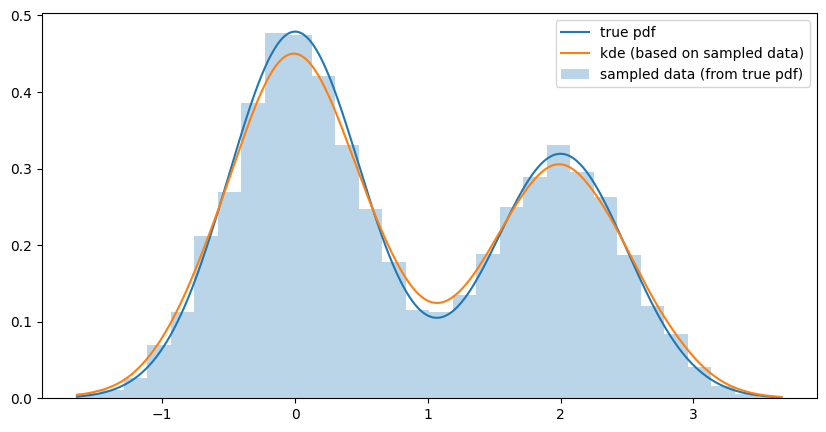

In [5]:
# Generate data from Gaussian mixture
def gaussian(x, mu, sigma): 
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * sigma**2))

def guassian_mixture(x, Pi, Mu, Sigma):
    assert sum(Pi) == 1
    return sum([pi * gaussian(x, mu, sigma) for pi, mu, sigma in zip(Pi, Mu, Sigma)])
         
Pi = [0.6, 0.4]
Mu = [0.0, 2.0]
Sigma = [0.5, 0.5]

# Sample from gaussian mixture
n = 10_000
mixture_idx = np.random.choice(len(Pi), n, p=Pi)
sampled_data_true = np.array([np.random.normal(Mu[i], Sigma[i]) for i in mixture_idx])

# Sample from KDE
kde = scipy.stats.gaussian_kde(sampled_data_true)
sampled_data_kde = kde.resample(10_000)

# Plotting
xmin, xmax = (min(sampled_data_true), max(sampled_data_true))
x_values = np.linspace(xmin, xmax, 1000)
true_pdf = [guassian_mixture(x, Pi, Mu, Sigma) for x in x_values]
fig, axs = plt.subplots(1,1, figsize=(10,5))

# Plot sampled data vs. true distribution
axs.plot(x_values, true_pdf, label='true pdf', color='tab:blue')
axs.plot(x_values, kde(x_values), label='kde (based on sampled data)', color='tab:orange')
axs.hist(sampled_data_true, alpha=0.3, density=True, bins=30, label='sampled data (from true pdf)', color='tab:blue')
axs.legend()


In [125]:
# Parameters
n = 10_000
c = 3
cov = np.matrix([[0.5, 0.2],[0.2, 2.0]])
mean = np.array([0.0, 1.0])

# Genreate and split data
data = np.random.multivariate_normal(mean=mean, cov=cov, size=n)
edge_data = data[data[:,1] >= c]
M = len(edge_data) // 10
edge_data = edge_data[M:]
normal_data = data [:M] 
normal_data = data[:200]
p_edge = len(normal_data[normal_data[:,1] >= c]) / len(normal_data)

# Print data info
print(f"# edge data: {len(edge_data)}\n# normal data: {len(normal_data)}\nP(edge): {100 * p_edge:.2f}%")

# edge data: 693
# normal data: 200
P(edge): 6.50%


In [126]:
# Fit KDEs
kde_normal = scipy.stats.gaussian_kde(normal_data.T)
kde_normal_only = scipy.stats.gaussian_kde(normal_data[normal_data[:,1] < c].T)
kde_edge_only =  scipy.stats.gaussian_kde(edge_data.T)

# Resample from KDEs
n_normal = 100000
n_edge = int(p_edge * n_normal)
normal_resampled = kde_normal.resample(size=n_normal).T
normal_only_resampled = kde_normal_only.resample(size=n_normal).T
edge_resampled = kde_edge_only.resample(size=n_edge).T

# Reconstruct dataset:
data_resampled = np.concatenate((normal_only_resampled, edge_resampled))

Text(0.5, 1.0, 'True pdf vs. resampled data')

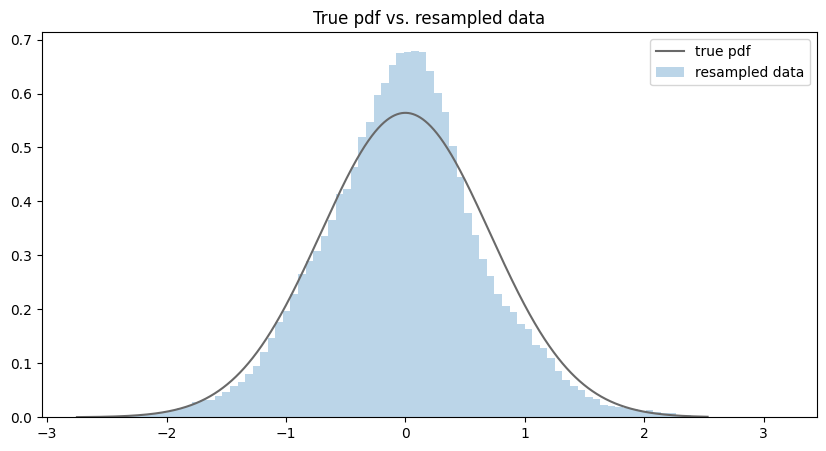

In [132]:

# Plot sampled data vs. true distribution
fig, axs = plt.subplots(1,1, figsize=(10,5))
xmin, xmax = (min(data[:,0]), max(data[:,0]))
x_values = np.linspace(xmin, xmax, 10000)
y_values = [gaussian(x, mean[0], np.sqrt(cov[0,0])) for x in x_values]

axs.plot(x_values, y_values, color='dimgrey', label='true pdf')
# axs.hist(data[:,0],  alpha=0.3, density=True, bins=90, label='sampled from true pdf')
axs.hist(data_resampled[:,0],  alpha=0.3, density=True, bins=90, label='resampled data')
axs.legend()
plt.title("True pdf vs. resampled data")

Text(0.5, 1.0, 'Sampled data from kde fitted on normal data only vs sampled data from kde fitted on edge')

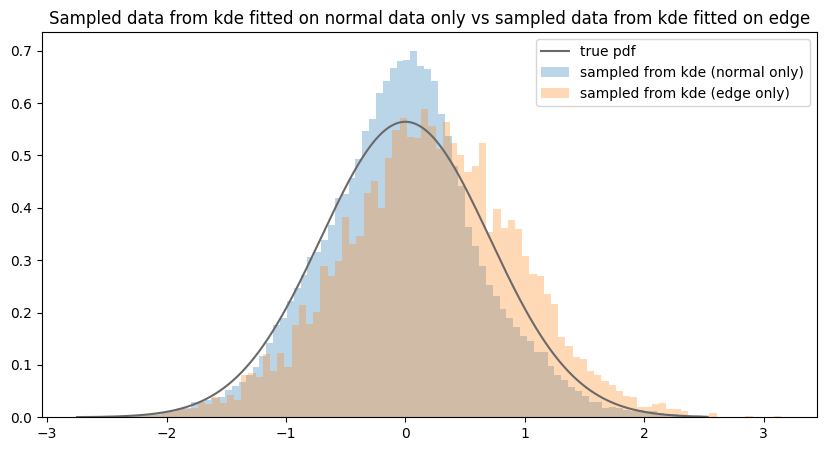

In [131]:
fig, axs = plt.subplots(1,1, figsize=(10,5))
xmin, xmax = (min(data[:,0]), max(data[:,0]))
x_values = np.linspace(xmin, xmax, 10000)
y_values = [gaussian(x, mean[0], np.sqrt(cov[0,0])) for x in x_values]

axs.plot(x_values, y_values, color='dimgrey', label='true pdf')
axs.hist(normal_only_resampled[:,0],  alpha=0.3, density=True, bins=90, label='sampled from kde (normal only)')
axs.hist(edge_resampled[:,0],  alpha=0.3, density=True, bins=90, label='sampled from kde (edge only)')
axs.legend()
plt.title("Sampled data from kde fitted on normal data only vs sampled data from kde fitted on edge")

Text(0.5, 1.0, 'sampled data from normal data vs. sampled data from reconstruced KDE')

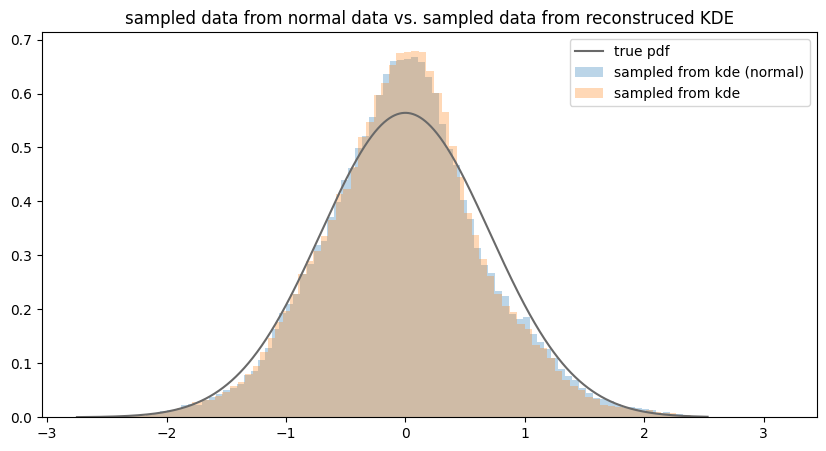

In [130]:
fig, axs = plt.subplots(1,1, figsize=(10,5))
xmin, xmax = (min(data[:,0]), max(data[:,0]))
x_values = np.linspace(xmin, xmax, 10000)
y_values = [gaussian(x, mean[0], np.sqrt(cov[0,0])) for x in x_values]

axs.plot(x_values, y_values, color='dimgrey', label='true pdf')
axs.hist(normal_resampled[:,0],  alpha=0.3, density=True, bins=90, label='sampled from kde (normal)')
axs.hist(data_resampled[:,0],  alpha=0.3, density=True, bins=90, label='sampled from kde')
axs.legend()
plt.title("sampled data from normal data vs. sampled data from reconstruced KDE")